# Figure 2

Run the steps below to generate the data and plot of Figure 2.

**Lennart van Sluijs** // 2019 Jan 8 // Leiden Observatory // vansluijs@strw.leidenuniv.nl

In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt
from aux import get_flist
from aux import tableau20
import os

# Calculate period completeness
First define some functions to perform the calculation.

In [32]:
def transit_duration(Rs, Rp, a, P, b):
    """
    Description:
        Analytical estimate of the transit duration.
    Input:
        Rs - radius of the star
        Rp - radius of the planet
        a - semi-major axis
        P - orbital period
        b - impact parameter
    Output:
        Tdur - transit duration
    """
    
    # caclulate transit duration
    Tdur = P/(np.pi * u.rad) \
    * np.arcsin( np.sqrt( (Rs + Rp)**2 - (b*Rs)**2 )/a )
    
    return Tdur

def a2P(a, Ms):
    """
    Description:
        Convert the semi-major axis into a period using Kepler's third law.
    Input:
        a - semi-major axis
        Ms - stellar mass
    Output:
        P - period of the planet
    """
    
    # get period from Kepler's third law
    P = np.sqrt((4*np.pi**2*a**3)/(const.G * Ms))
    
    return P

def init_time(inputfolder):
    """
    Description:
        Create a list of times for all time frames of all observations.
    Input:
        inputfolder - contains time data for all observations
    Output:
        time - list of times of all observations
    """
    
    # get all files containing timestamp data
    flist = get_flist(inputfolder)
    
    # create list of times
    time = []
    for fname in flist:
        fname_time = np.loadtxt(os.path.join(inputfolder, fname))
        time.append(fname_time)
    time = np.array(time)
    
    return time
    
def init_obs_mask(time, osf):
    """
    Description:
        Create an oversampled mask of times when observations where taken.
    Input:
        time - numpy array with times for every observed night
        osf - oversampling factor
    Output:
        t - time series corresponding with observational mask
        obs_mask - observational mask
    """
    
    # create oversampled time grid
    t = np.linspace(time[0][0], time[-1][-1], osf)
    obs_mask = np.zeros(len(t))

    # create observation window
    for n in range(len(time)):
        obs_mask[np.where(np.logical_and(t > time[n][0],
                                         t < time[n][-1]))] = 1.0
    
    return t, obs_mask

def init_transit_mask(Tdur, t):
    """
    Description:
        Create a mask of the duration of a transit with shared x-axis
        with the observation mask.
    Input:
        Tdur - duration of transit
        t - time series corresponding with observational mask
    Output:
        transit_mask - transit mask
    """
    
    # mask of length of the transit duration for the specified time grid
    t -= t[0]
    transit_mask = t[np.where(t < Tdur.to(u.d).value)]
    transit_mask[:] = 1.0
    
    return transit_mask

def convolve_masks(obs_mask, transit_mask):
    """
    Description:
        Convolve the in-transit mask with the observation mask.
    Input:
        transit_mask - transit mask
        obs_mask - observational mask
    Output:
        conv_masks - convolution of both input masks
    """
    
    # convolve observation window with transit duration window
    conv_masks = np.convolve(obs_mask, transit_mask, mode = 'same')
    conv_masks[np.where(conv_masks > 0.)] = 1. # set same weight everywhere
    
    return conv_masks

def fold_lc(t, f, per):
    """
    Description:
        Fold light curve.
    Input:
        t - list of times
        f - list of fluxes
        per - period for which to fold data
    Output:
        tf - list of folded times
        ff - list of folded fluxes
    """
    
    # fold light curve data
    folded = (t % per)
    ind = np.array(folded).argsort()
    tf = folded[ind]
    ff = f[ind]
    
    return tf, ff

def bin_array(x, nbins, median = False):
    """
    Description:
        Bin data.
    Input:
        x - list of values
        nbins - number of bins to use
    Ouput:
        xb - list of binned values
    """
    
    # bin with equal binsize
    xs = np.array_split(x, nbins)
    xb = [np.mean(xs[j]) for j in range(0, nbins)]
        
    return xb

def calculate_completeness(t, P, conv_masks):
    """
    Description:
        Get period completeness for the specified exoplanet orbital period 
        and observation window.
    Input:
        t - oversampled time grid to use
        P - exoplanet orbital period
        conv_masks - observation window convolved with the transit duration
    Output:
        completeness - period completeness
    """
    
    # two situation: (1) period > observation window, for which the observation
    # window over the gaps is the completeness
    dt = t[-1] - t[0]
    Np = int(dt/P.to(u.d).value) + 1
    if (t[-1] - t[0]) - P.to(u.d).value < 0:
        completeness = float(len(np.where(conv_masks > 0)[0]))/ \
        float(len(conv_masks) * (P.to(u.d).value/(t[-1] - t[0])))
    # (2) period < observation window, for which we fold first and apply the
    # same routine
    else:
        for n in range(Np):
            ind = np.where(np.logical_and(t >= n * P.to(u.d).value,
                                          t < (n+1) * P.to(u.d).value))[0]     
            if n == 0:
                xf = np.linspace(0, P, len(ind))
                yf = np.zeros(len(xf))
            yf[0:len(ind)] += conv_masks[ind]
        completeness = float(len(np.where(yf > 0)[0]))/float(len(yf))
    
    return completeness

The following function calculates the period completeness.

In [36]:
def get_completeness(a, Rp, Rs, Ms, b, osf):
    """
    Description:
        Calculate the period completeness.
    Input:
        a - list of semi-major axes to explore
        Rp - list of planet radii to explore
        Ms - stellar mass
        Rs - stellar radius
        b - impact parameter
        osf - oversampling factor to use for the masks
    Output:
        completeness - completeness(a)
    """
    
    # load time stamps for observation window
    time = init_time(os.path.join('../data/frame_times'))
    
    # explore the whole parameter space
    completeness = np.zeros(len(a))
    for i in range(len(a)):
        
        print('Calculate completeness (' + str(i+1) + '/' + str(len(a)) + ')')
        
        # get period and transit duration
        P = a2P(a[i], Ms)
        Tdur = transit_duration(Rs, Rp, a[i], P, b)
        
        # get observation window and convolve it with the transit duration
        t, obs_mask = init_obs_mask(time, osf)
        transit_mask = init_transit_mask(Tdur, t)
        conv_masks = convolve_masks(obs_mask, transit_mask)
        
        # calculate the completeness
        completeness[i] = calculate_completeness(t, P, conv_masks)
    
    return completeness

Perform the calculation. This takes several minutes on my personal laptop. Using a lower oversampling factor will speed up the calculation, but uses a less accurate observation window.

In [37]:
# load time stamps for observation window
time = init_time(os.path.join('../data/frame_times'))

# set system parameters
Rs = 1.8 * u.solRad
Rp = 1.0 * u.R_jup
Ms = 1.73 * u.solMass
b = 0
osf = 2000000 # used for the oversampled timegrid, higher is more accurate, but
# computationally heavy
a = np.linspace(0.01, 3., 200) * u.au

# find period completeness
completeness = get_completeness(a, Rp, Rs, Ms, b, osf)

Calculate completeness (1/200)
Calculate completeness (2/200)
Calculate completeness (3/200)
Calculate completeness (4/200)
Calculate completeness (5/200)
Calculate completeness (6/200)
Calculate completeness (7/200)
Calculate completeness (8/200)
Calculate completeness (9/200)
Calculate completeness (10/200)
Calculate completeness (11/200)
Calculate completeness (12/200)
Calculate completeness (13/200)
Calculate completeness (14/200)
Calculate completeness (15/200)
Calculate completeness (16/200)
Calculate completeness (17/200)
Calculate completeness (18/200)
Calculate completeness (19/200)
Calculate completeness (20/200)
Calculate completeness (21/200)
Calculate completeness (22/200)
Calculate completeness (23/200)
Calculate completeness (24/200)
Calculate completeness (25/200)
Calculate completeness (26/200)
Calculate completeness (27/200)
Calculate completeness (28/200)
Calculate completeness (29/200)
Calculate completeness (30/200)
Calculate completeness (31/200)
Calculate complet

KeyboardInterrupt: 

# Plot the coverage

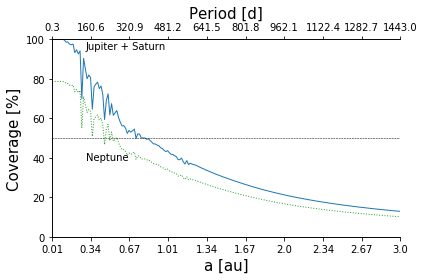

In [6]:
def plot_coverage(a, completeness, outputfolder):
    """
    Description:
        Create a plot of the coverage for a set different planet radii
        and semi-major axes.
    Input:
        a - list of semi-major axes to explore
        completeness - list of corresponding period completeness
        outputfolder - save plot here
    """
    
    # create folder if it does not exist yet
    if not os.path.exists(outputfolder):
            os.makedirs(outputfolder)
    
    # explore the whole parameter space
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # plot sensitivity for the white noise simulation
    sensitivity = [1., 0.7870813397]
    yoffsets = [5, 40]
    labels = ['Jupiter + Saturn', 'Neptune']
    ls_list = ['-', ':']
    for i in range(2):
        coverage = sensitivity[i] * completeness * 100
        ax.plot(a, coverage, color = tableau20[i*4], ls = ls_list[i],
                lw = 1., zorder = len(labels)-i)
        ax.text(0.3, sensitivity[i]*100 - yoffsets[i], s = labels[i])
        
    # set xticks
    xticks = np.linspace(a[0].to(u.au).value, a[-1].to(u.au).value, 10)
    xticklabels = np.round(np.linspace(a[0].to(u.au).value,
                                       a[-1].to(u.au).value,
                                       10), 2)    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('a [au]', size = 15)
    ax.set_ylabel('Coverage [%]', size = 15)
    ax.axhline(y=50, ls = '--', color = 'k', lw = 0.5)
    ax.set_xlim(a[0].to(u.au).value, a[-1].to(u.au).value)
    ax.set_ylim(0., 100.0)
       
    # set xticks above plot for period range
    ax2 = ax.twiny()
    xticks = np.linspace(0, 1, 10)
    xticklabels = np.round(np.linspace(a2P(a[0], Ms).to(u.d).value,
                                       a2P(a[-1], Ms).to(u.d).value,
                                       10), 1)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
    ax2.set_xlabel('Period [d]', size = 15)
    
    # set right spine unvisble
    ax.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # plot tight layout
    plt.tight_layout()
    
    # save the plot
    plt.savefig(os.path.join(outputfolder, 'figure2.png'), dpi = 300)
    plt.savefig(os.path.join(outputfolder, 'figure2.pdf'))
    
# create a plot of the coverage
outputfolder = '../output/figure2'
plot_coverage(a, completeness, outputfolder)